In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/home/data/fhz/project/phmap_package')

import scanpy as sc
import phmap


   ____  _   __  __    _    ____  
  |  _ \| | |  \/  |  / \  |  _ \ 
  | |_) | |_| |\/| | / _ \ | |_) |
  |  __/|  _  |  | |/ ___ \|  __/ 
  |_|   |_| |_|  |_/_/   \_\_|    
                                  
  🔬 Multi-task Learning Framework for Cell Type Classifier
  🫁 pretrained model on pulmonary hypertension scRNA-seq data
    
🔖 Version: 0.1.0

🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 4090
   • Total memory: 23.6 GB
   • Compute capability: 8.9
   • CUDA version: 12.1



### Load model

In [2]:
model = phmap.load_pretrained_model('full_model')

INFO:phmap.core.classifier:Model loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth
INFO:phmap.core.predictor:Model and metadata loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth and /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full_metadata.pkl


#### Test dataset

##### Preprocessing

In [3]:
query = sc.read_h5ad("phmap/test_data/GSE228643_PF-PH/PRJNA950922_PF_PH_raw.h5ad")
query

AnnData object with n_obs × n_vars = 41493 × 36601
    obs: 'sample', 'dataset', 'group', 'batch'
    var: 'ENSEMBL', 'SYMBOL'

In [4]:
query.layers['counts'] = query.X.copy()

In [5]:
query.var.head()

,ENSEMBL,SYMBOL
ENSG00000243485,ENSG00000243485,MIR1302-2HG
ENSG00000237613,ENSG00000237613,FAM138A
ENSG00000186092,ENSG00000186092,OR4F5
ENSG00000238009,ENSG00000238009,AL627309.1
ENSG00000239945,ENSG00000239945,AL627309.3


In [6]:
# use symbol as gene name
# Remove duplicated genes based on SYMBOL
query = query[: ,~query.var["SYMBOL"].duplicated()]
query.var_names = query.var["SYMBOL"].copy()
query.var.index.name = None
query

AnnData object with n_obs × n_vars = 41493 × 36591
    obs: 'sample', 'dataset', 'group', 'batch'
    var: 'ENSEMBL', 'SYMBOL'
    layers: 'counts'

In [7]:
query.var.head()

,ENSEMBL,SYMBOL
MIR1302-2HG,ENSG00000243485,MIR1302-2HG
FAM138A,ENSG00000237613,FAM138A
OR4F5,ENSG00000186092,OR4F5
AL627309.1,ENSG00000238009,AL627309.1
AL627309.3,ENSG00000239945,AL627309.3


##### Calculate some qc indicators

In [8]:
# 线粒体基因
query.var["mt"] = query.var_names.str.startswith("MT-")
# 核糖体基因
query.var["ribo"] = query.var_names.str.startswith(("RPS", "RPL"))
# 血红蛋白基因
query.var["hb"] = query.var_names.str.contains(("^HB[^(P)]")) 

sc.pp.calculate_qc_metrics(
    query, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

Text(0.5, 1.0, 'perc_mt distribution')

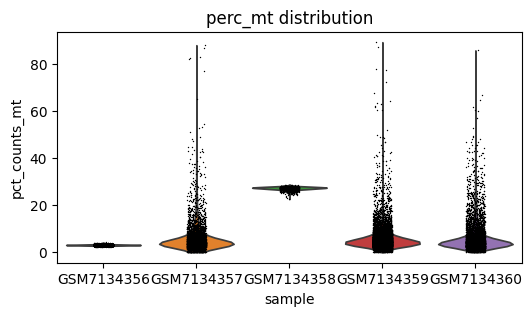

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 3))
sc.pl.violin(query, keys=["pct_counts_mt"], groupby="sample", ax=ax,
             show=False)
plt.title("perc_mt distribution")

In [10]:
unnormal_sample = ["GSM7134356", "GSM7134358"]
query = query[~query.obs["sample"].isin(unnormal_sample)].copy()

##### Quality control

In [11]:
n0 = query.shape[0]
print(f'Original cell number: {n0}')

Original cell number: 28021


In [12]:
import numpy as np
tresh={
    # Using a relaxed mitochondrial filtering threshold
    'mito_perc': 30, 'nUMIs': 500, 'detected_genes': 200
}

query.obs['passing_mt'] = query.obs['pct_counts_mt'] < tresh['mito_perc']
query.obs['passing_nUMIs'] = query.obs['total_counts'] > tresh['nUMIs']
query.obs['passing_ngenes'] = query.obs['n_genes_by_counts'] > tresh['detected_genes']

print(f'Lower treshold, nUMIs: {tresh["nUMIs"]}; filtered-out-cells: {n0-np.sum(query.obs["passing_nUMIs"])}')
print(f'Lower treshold, n genes: {tresh["detected_genes"]}; filtered-out-cells: {n0-np.sum(query.obs["passing_ngenes"])}')
print(f'Lower treshold, mito %: {tresh["mito_perc"]}; filtered-out-cells: {n0-np.sum(query.obs["passing_mt"])}')


Lower treshold, nUMIs: 500; filtered-out-cells: 9
Lower treshold, n genes: 200; filtered-out-cells: 180
Lower treshold, mito %: 30; filtered-out-cells: 211


In [13]:
QC_test = (query.obs['passing_mt']) & (query.obs['passing_nUMIs']) & (query.obs['passing_ngenes'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last QC (and its chosen options): {n0-np.sum(QC_test)}')
query = query[QC_test, :].copy()
n2 = query.shape[0]

# Store cleaned adata
print(f'Cells retained after filtering: {n2}, {n0-n2} removed.')

Total cell filtered out with this last QC (and its chosen options): 374
Cells retained after filtering: 27647, 374 removed.


In [14]:
sc.pp.filter_genes(query, min_cells=10)

### Prediction

##### Perform prediction on integrated data

In [15]:
%%time
result = phmap.predict(adata = query, return_probabilities=True)

INFO:phmap.core.classifier:Model loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth
INFO:phmap.core.predictor:Model and metadata loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth and /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full_metadata.pkl
INFO:phmap.core.predictor:Loaded default model 'full_model'


INFO:phmap.core.predictor:Prediction completed for 27647 cells


CPU times: user 5 s, sys: 1.2 s, total: 6.21 s
Wall time: 6.2 s


In [16]:
# add prediction to anndata
result.to_adata(query)

AnnData object with n_obs × n_vars = 27647 × 20104
    obs: 'sample', 'dataset', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'predicted_anno_lv1', 'predicted_anno_lv1_prob', 'predicted_anno_lv2', 'predicted_anno_lv2_prob', 'predicted_anno_lv3', 'predicted_anno_lv3_prob', 'predicted_anno_lv4', 'predicted_anno_lv4_prob'
    var: 'ENSEMBL', 'SYMBOL', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'
    layers: 'counts'

In [18]:
query.obs.head()

,sample,dataset,group,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,...,passing_nUMIs,passing_ngenes,predicted_anno_lv1,predicted_anno_lv1_prob,predicted_anno_lv2,predicted_anno_lv2_prob,predicted_anno_lv3,predicted_anno_lv3_prob,predicted_anno_lv4,predicted_anno_lv4_prob
GSM7134357-AAACCTGAGAAGATTC-1,GSM7134357,PRJNA950922,HC,1,2490,7.820440,7475,8.919453,23.464883,70,...,True,True,Endothelial,1.000000,EC lymphatic,1.000000,EC lymphatic,1.000000,EC_c1_lymphatic_CCL21,1.000000
GSM7134357-AAACCTGAGTACATGA-1,GSM7134357,PRJNA950922,HC,1,1051,6.958448,2487,7.819234,25.774025,111,...,True,True,Lymphocyte,0.999999,T,0.999985,CD8+ T,0.966997,CD8T_c3_T_GZMH,0.925694
GSM7134357-AAACCTGCAATACGCT-1,GSM7134357,PRJNA950922,HC,1,1201,7.091742,3546,8.173857,26.254935,243,...,True,True,Myeloid,1.000000,Monocyte,1.000000,Mono classical,1.000000,Mono_c1_classical_CD14,1.000000
GSM7134357-AAACCTGCACAGACTT-1,GSM7134357,PRJNA950922,HC,1,1143,7.042286,2934,7.984463,21.642808,119,...,True,True,Lymphocyte,1.000000,T,1.000000,CD4+ T,1.000000,CD4T_c2_T_CXCR6,0.999997
GSM7134357-AAACCTGCACGGCCAT-1,GSM7134357,PRJNA950922,HC,1,1654,7.411556,5831,8.671115,26.873607,200,...,True,True,Myeloid,1.000000,DC,0.999814,DC,0.999955,DC_c3_cDC_CD1E,0.999995


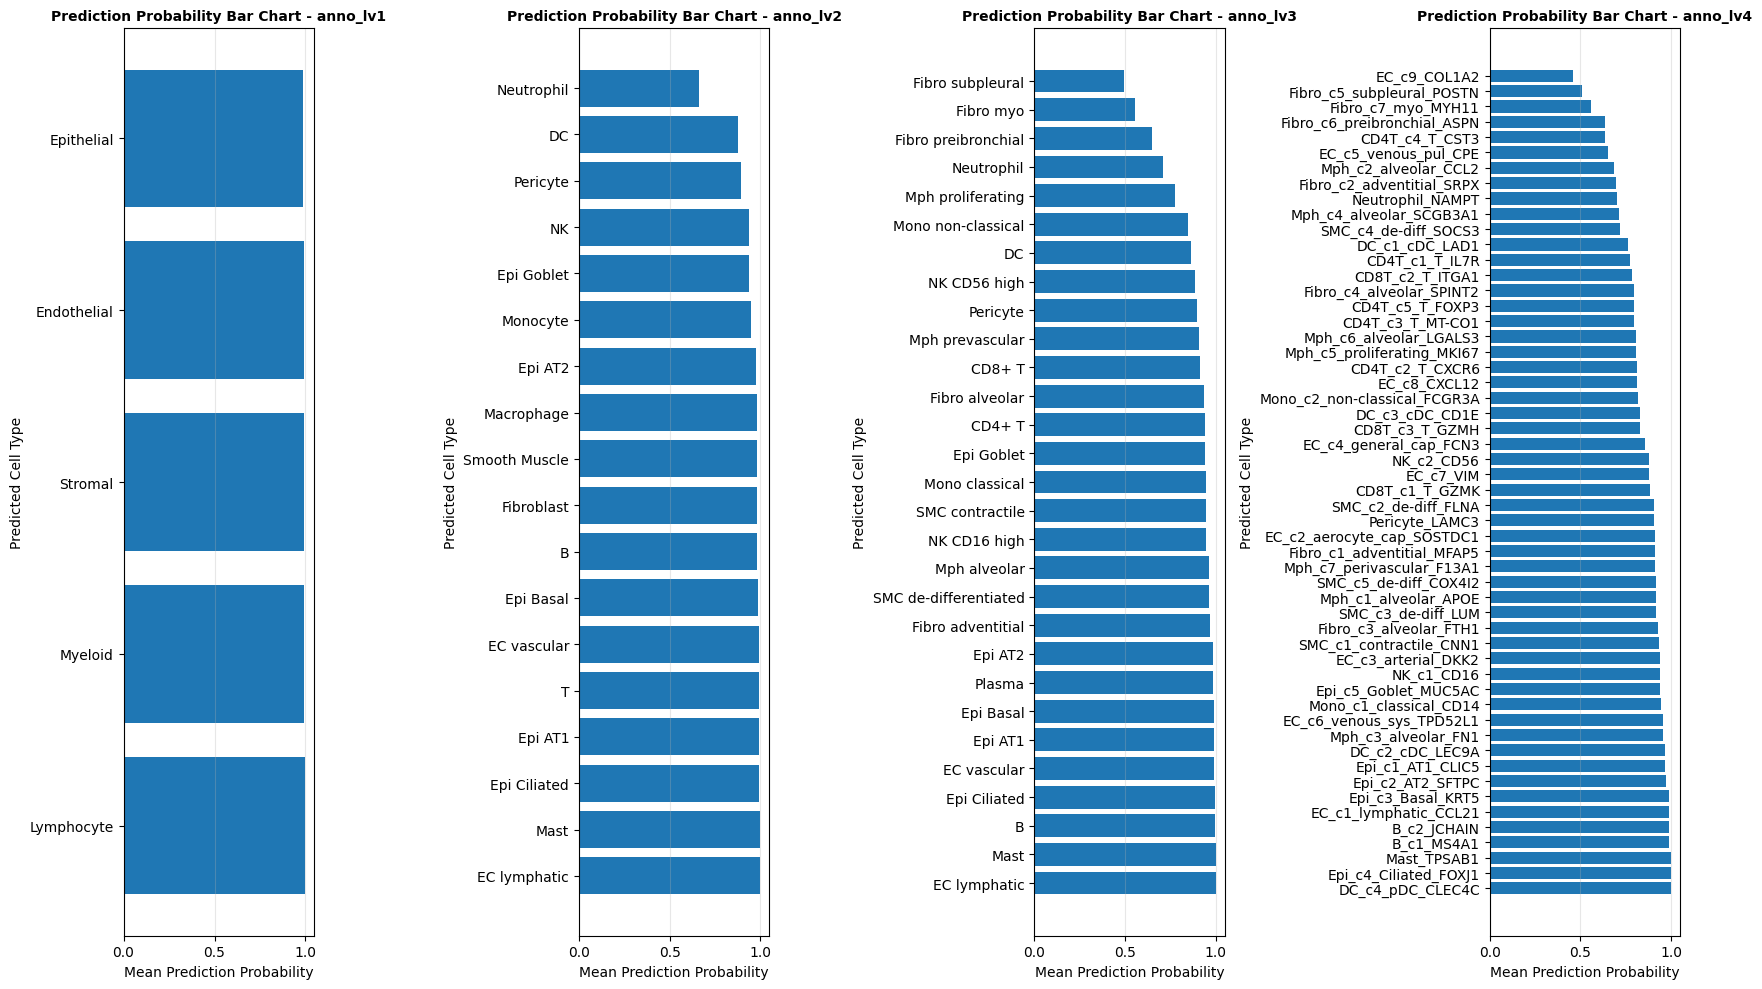

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(17, 10))  # 并排画
for i, label in enumerate(['anno_lv1', 'anno_lv2', 'anno_lv3', 'anno_lv4']):
    phmap.pl.plot_probability_bar(result, label_columns=[label], figsize=(4, 5), orientation='horizontal', ax=axes[i])
plt.tight_layout()
plt.show()

In [32]:
os.makedirs('figures/GSE228643_PF-PH', exist_ok=True)

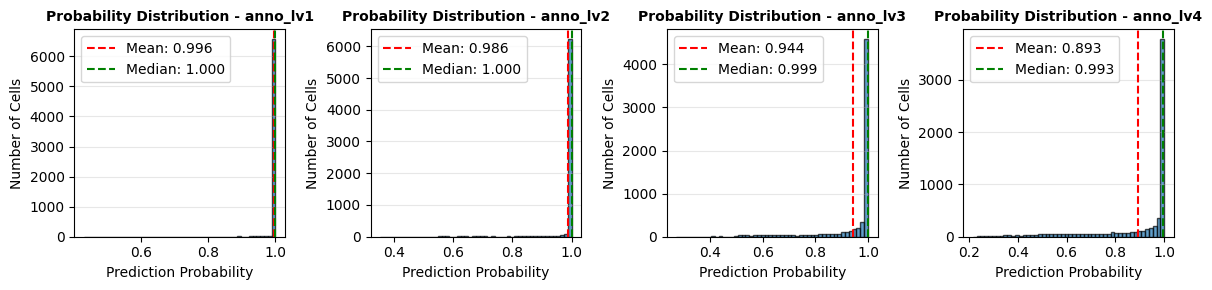

In [33]:
phmap.pl.plot_probability_distribution(result, label_columns=['anno_lv1', 'anno_lv2', 'anno_lv3', 'anno_lv4'], figsize=(3, 3), show=False)
plt.savefig('figures/GSE228643_PF-PH/PRJNA950922_PF_PH_raw_anno_lv1_2_3_4.pdf', bbox_inches='tight')
plt.show()

In [24]:
import scvi
import torch
torch.set_float32_matmul_precision('high')

def find_hvg(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    return adata

def perform_scvi_ref(adata):
    adata_scvi = adata[:, adata.var["highly_variable"]].copy()
    scvi.model.SCVI.setup_anndata(adata_scvi, layer='counts', batch_key='sample')
    scvi_ref = scvi.model.SCVI(
        adata_scvi,
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
    )
    scvi_ref.train()
    return scvi_ref

def perform_scanvi(adata, scvi_ref):
    adata_scvi = adata[:, adata.var["highly_variable"]].copy()
    scvi.model.SCVI.setup_anndata(adata_scvi, layer='counts', batch_key='sample')
    lvae = scvi.model.SCANVI.from_scvi_model(
        scvi_ref,
        adata=adata_scvi,
        labels_key="predicted_anno_lv3",
        unlabeled_category="Unknown",
    )
    lvae.train(max_epochs=40, n_samples_per_label=20) 
    return lvae

In [25]:
query = find_hvg(query)
scvi_model = perform_scvi_ref(query)
scanvi_model = perform_scanvi(query, scvi_model)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Training for 40 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 40/40: 100%|██████████| 40/40 [04:06<00:00,  6.15s/it, v_num=1, train_loss_step=225, train_loss_epoch=208]

INFO: `Trainer.fit` stopped: `max_epochs=40` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [04:06<00:00,  6.16s/it, v_num=1, train_loss_step=225, train_loss_epoch=208]


In [26]:
query.obsm["X_scANVI"] = scanvi_model.get_latent_representation()
sc.pp.neighbors(query, use_rep="X_scANVI", n_neighbors=15)
sc.tl.umap(query)

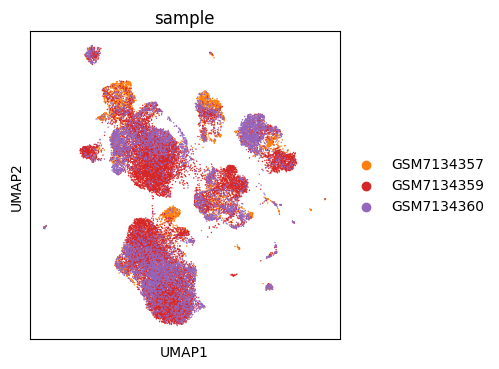

In [40]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(query, color=['sample'], ncols=1, ax=ax, show=False)
for ax in fig.axes:
        for collection in ax.collections:
            collection.set_rasterized(True)
fig.savefig('figures/GSE228643_PF-PH/PRJNA950922_PF_PH_sample_umap.pdf', bbox_inches='tight', dpi=300)
plt.show()

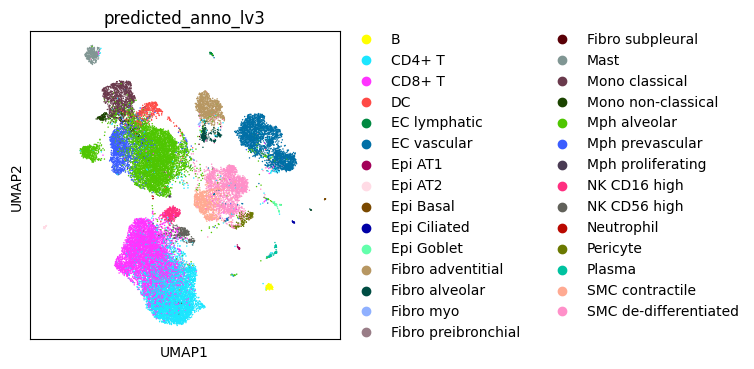

In [35]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(query, color=['predicted_anno_lv3'], ncols=1, ax=ax, show=False)
for ax in fig.axes:
        for collection in ax.collections:
            collection.set_rasterized(True)
fig.savefig('figures/GSE228643_PF-PH/PRJNA950922_PF_PH_raw_anno_lv3_umap.pdf', bbox_inches='tight', dpi=300)
plt.show()

#### Perform prediction on each single sample

In [25]:
query2 = query.copy()
query2.obs = query2.obs.drop(columns=['predicted_anno_lv1', 'predicted_anno_lv1_prob', 'predicted_anno_lv2', 'predicted_anno_lv2_prob', 'predicted_anno_lv3', 'predicted_anno_lv3_prob', 'predicted_anno_lv4', 'predicted_anno_lv4_prob'])
query2

AnnData object with n_obs × n_vars = 27647 × 20104
    obs: 'sample', 'dataset', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'ENSEMBL', 'SYMBOL', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'
    layers: 'counts'

In [26]:
query_list = [query2[query2.obs['sample'] == sample].copy() for sample in query2.obs['sample'].unique()]
[ad.shape for ad in query_list]

[(4406, 20104), (16467, 20104), (6774, 20104)]

In [27]:
%%time
result_list = []
for ad in query_list:
    result = phmap.predict(adata = ad, return_probabilities=True)
    ad = result.to_adata(ad)
    result_list.append(result)

INFO:phmap.core.predictor:Prediction completed for 4406 cells
INFO:phmap.core.predictor:Prediction completed for 16467 cells
INFO:phmap.core.predictor:Prediction completed for 6774 cells


CPU times: user 5.28 s, sys: 1.03 s, total: 6.31 s
Wall time: 6.3 s


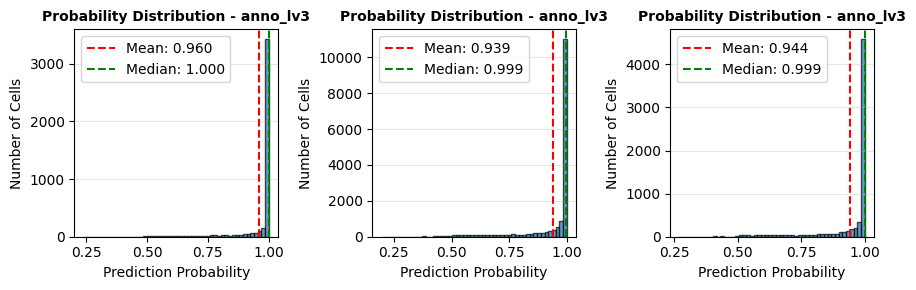

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(result_list), figsize=(3 * len(result_list), 3))
if len(result_list) == 1:
    axs = [axs]
for n, ax in enumerate(axs):
    phmap.pl.plot_probability_distribution(result_list[n], label_columns=['anno_lv3'], ax=ax)
plt.tight_layout()
plt.show()

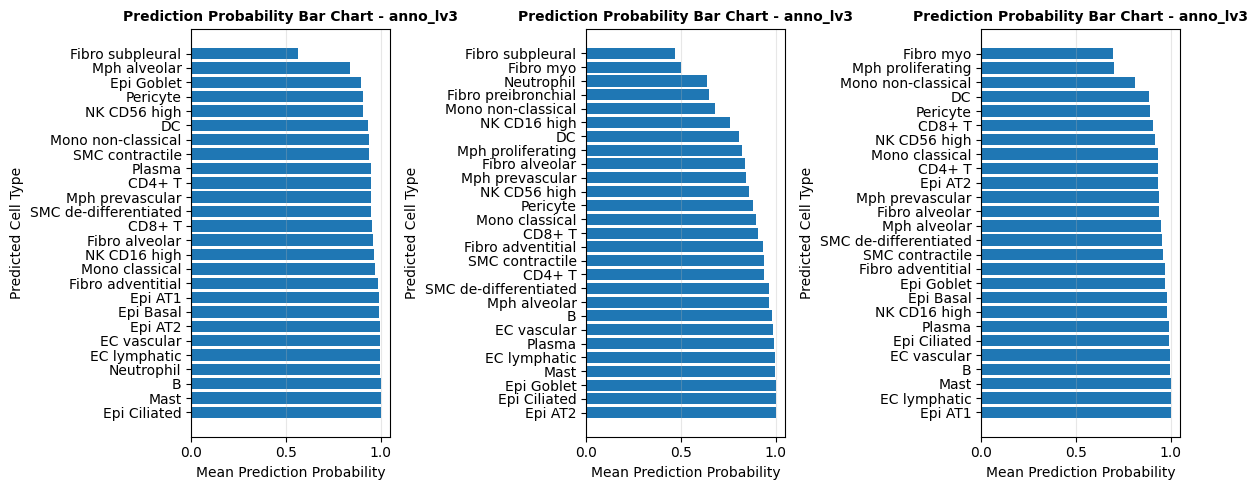

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(result_list), figsize=(4 * len(result_list), 5))
if len(result_list) == 1:
    axes = [axes]
for n, ax in enumerate(axes):
    phmap.pl.plot_probability_bar(result_list[n], label_columns=['anno_lv3'], orientation='horizontal', ax=ax)
plt.tight_layout()
plt.show()

In [30]:
# merged
query2 = query_list[0].concatenate(query_list[1:])
query2

AnnData object with n_obs × n_vars = 27647 × 20104
    obs: 'sample', 'dataset', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'predicted_anno_lv1', 'predicted_anno_lv1_prob', 'predicted_anno_lv2', 'predicted_anno_lv2_prob', 'predicted_anno_lv3', 'predicted_anno_lv3_prob', 'predicted_anno_lv4', 'predicted_anno_lv4_prob'
    var: 'ENSEMBL', 'SYMBOL', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts'

Then, you could use merged anndata for down-stream analysis.